# Description

It selects a set of specific gene pairs from a tissue, and checks if relationship are replicated on other tissues.
It also uses GTEx metadata (such as sex) to explain relationships.

# Modules

In [1]:
from pathlib import Path

import pandas as pd

from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

from ccc import conf
from ccc.coef import ccc

# Settings

In [2]:
# this gene pair was originally found with ccc on whole blood
# interesting: https://clincancerres.aacrjournals.org/content/26/21/5567.figures-only
# gene0_id, gene1_id = "ENSG00000148153.13", "ENSG00000125812.15"
# gene0_symbol, gene1_symbol = "CYTIP", "RASSF2"

# Paths

In [3]:
# BASE_DIR = Path("/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu/base/gtex")

In [4]:
# TISSUE_DIR = BASE_DIR / "data_by_tissue"
# assert TISSUE_DIR.exists()

BASE_DIR = Path("/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu/base/gtex")
TISSUE_DIR = BASE_DIR / "data_by_tissue"
assert TISSUE_DIR.exists()

In [5]:
MANUSCRIPT_DIR = Path("/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript")
FIGURES_DIR = MANUSCRIPT_DIR / "content" / "images"
OUTPUT_FIGURE_DIR = (
    FIGURES_DIR
    / "gene_pairs"
)
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs')

# Data

## GTEx metadata

In [8]:
gtex_metadata = pd.read_pickle(BASE_DIR / "gtex_v8-sample_metadata.pkl")

In [9]:
gtex_metadata.shape

(22951, 66)

In [10]:
gtex_metadata.head()

,SUBJID,SEX,AGE,DTHHRDY,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,...,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
SAMPID,,,,,,,,,,,,,,,,,,,,,
GTEX-1117F-0003-SM-58Q7G,GTEX-1117F,Female,60-69,4.0,NaN,B1,NaN,NaN,Blood,Whole Blood,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-5DWSB,GTEX-1117F,Female,60-69,4.0,NaN,B1,NaN,NaN,Blood,Whole Blood,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-6WBT7,GTEX-1117F,Female,60-69,4.0,NaN,B1,NaN,NaN,Blood,Whole Blood,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0011-R10a-SM-AHZ7F,GTEX-1117F,Female,60-69,4.0,NaN,"B1, A1",NaN,NaN,Brain,Brain - Frontal Cortex (BA9),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0011-R10b-SM-CYKQ8,GTEX-1117F,Female,60-69,4.0,NaN,"B1, A1",NaN,7.2,Brain,Brain - Frontal Cortex (BA9),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Gene Ensembl ID -> Symbol mapping

In [11]:
gene_map = pd.read_pickle(BASE_DIR / "gtex_gene_id_symbol_mappings.pkl")

In [12]:
gene_map = gene_map.set_index("gene_ens_id")["gene_symbol"].to_dict()

In [13]:
assert gene_map["ENSG00000145309.5"] == "CABS1"

# Plot

In [15]:
def get_tissue_file(name):
    """
    Given a part of a tissue name, it returns a file path to the
    expression data for that tissue in GTEx. It fails if more than
    one files are found.

    Args:
        name: a string with the tissue name (or a part of it).

    Returns:
        A Path object pointing to the gene expression file for the
        given tissue.
    """
    tissue_files = []
    for f in TISSUE_DIR.glob("*.pkl"):
        if name in f.name:
            tissue_files.append(f)

    assert len(tissue_files) == 1
    return tissue_files[0]

In [16]:
# testing
_tmp = get_tissue_file("whole_blood")
assert _tmp.exists()

In [17]:
def simplify_tissue_name(tissue_name):
    return f"{tissue_name[0].upper()}{tissue_name[1:].replace('_', ' ')}"

In [18]:
assert simplify_tissue_name("whole_blood") == "Whole blood"
assert simplify_tissue_name("uterus") == "Uterus"

In [19]:
def plot_gene_pair(
    tissue_name, gene0, gene1, hue=None, kind="hex", ylim=None, bins="log"
):
    """
    It plots (joint plot) a gene pair from the given tissue. It saves the plot
    for the manuscript.
    """
    # merge gene expression with metadata
    tissue_file = get_tissue_file(tissue_name)
    tissue_data = pd.read_pickle(tissue_file).T[[gene0, gene1]]
    tissue_data = pd.merge(
        tissue_data,
        gtex_metadata,
        how="inner",
        left_index=True,
        right_index=True,
        validate="one_to_one",
    )
    
    display(f"Full data: {tissue_data.shape}")
    
    if hue is not None:
        tissue_data = tissue_data.dropna(subset=[hue])
        display(f"Full data without NaNs: {tissue_data.shape}")

    # get gene symbols
    gene0_symbol, gene1_symbol = gene_map[gene0], gene_map[gene1]
    display((gene0_symbol, gene1_symbol))

    # compute correlations for this gene pair
    _clustermatch = ccc(tissue_data[gene0], tissue_data[gene1])
    _pearson = pearsonr(tissue_data[gene0], tissue_data[gene1])[0]
    _spearman = spearmanr(tissue_data[gene0], tissue_data[gene1])[0]

    _title = f"{simplify_tissue_name(tissue_name)}\n$c={_clustermatch:.2f}$  $p={_pearson:.2f}$  $s={_spearman:.2f}$"

    other_args = {
        "kind": kind,  # if hue is None else "scatter",
        "rasterized": True,
    }
    if hue is None:
        other_args["bins"] = bins
    # else:
    #     other_args["hue_order"] = ["Male", "Female"]

    with sns.plotting_context("paper", font_scale=1.5):
        p = sns.jointplot(
            data=tissue_data,
            x=gene0,
            y=gene1,
            hue=hue,
            **other_args,
            # ylim=(0, 500),
        )

        if ylim is not None:
            p.ax_joint.set_ylim(ylim)

        gene_x_id = p.ax_joint.get_xlabel()
        gene_x_symbol = gene_map[gene_x_id]
        p.ax_joint.set_xlabel(f"{gene_x_symbol}", fontstyle="italic")

        gene_y_id = p.ax_joint.get_ylabel()
        gene_y_symbol = gene_map[gene_y_id]
        p.ax_joint.set_ylabel(f"{gene_y_symbol}", fontstyle="italic")

        p.fig.suptitle(_title)

        # save
        output_file = (
            OUTPUT_FIGURE_DIR
            / f"gtex_{tissue_name}-{gene_x_symbol}_vs_{gene_y_symbol}.svg"
        )
        display(output_file)

        plt.savefig(
            output_file,
            bbox_inches="tight",
            dpi=300,
            facecolor="white",
        )

    return tissue_data

## In whole blood (where this gene pair was found)

'Full data: (755, 68)'

('FOS', 'IL18R1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-FOS_vs_IL18R1.svg')

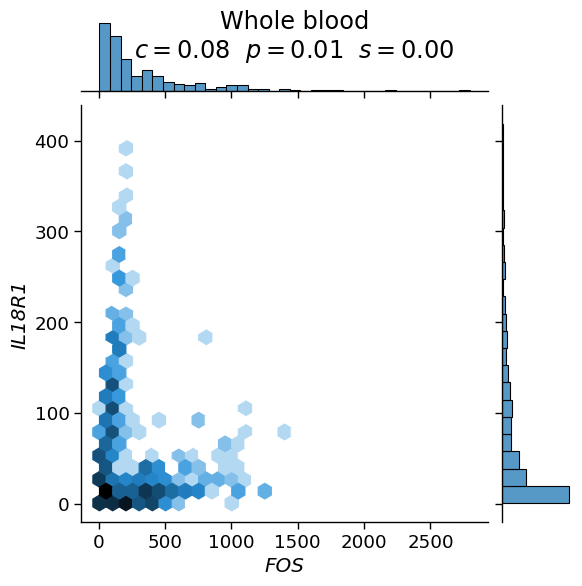

In [79]:
gene0_id, gene1_id = "ENSG00000170345.9  ENSG00000115604.10".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="SEX",
    # kind="scatter",
)

'Full data: (755, 68)'

('USP28', 'BICD2')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-USP28_vs_BICD2.svg')

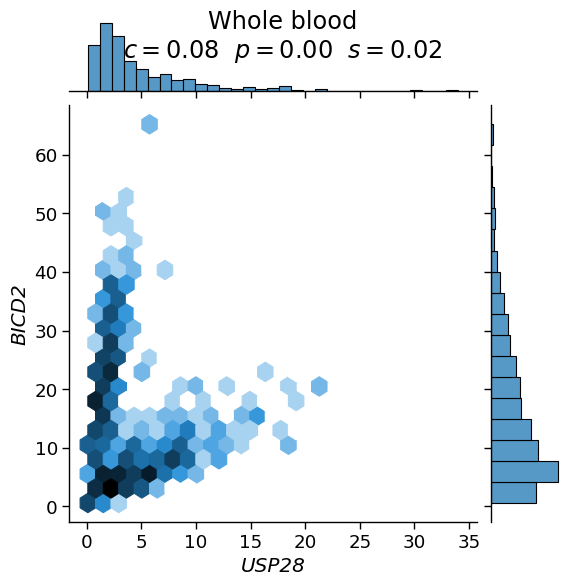

In [78]:
gene0_id, gene1_id = "ENSG00000048028.11 ENSG00000185963.13".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="SEX",
    # kind="scatter",
)

'Full data: (755, 68)'

('RP11-136I13.1', 'AC012307.2')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-RP11-136I13.1_vs_AC012307.2.svg')

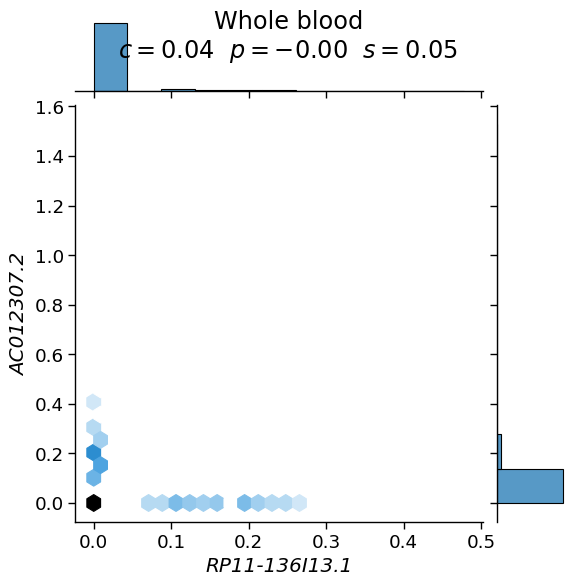

In [65]:
gene0_id, gene1_id = "ENSG00000250613.1  ENSG00000228873.1".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('ASTE1', 'USP28')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-ASTE1_vs_USP28.svg')

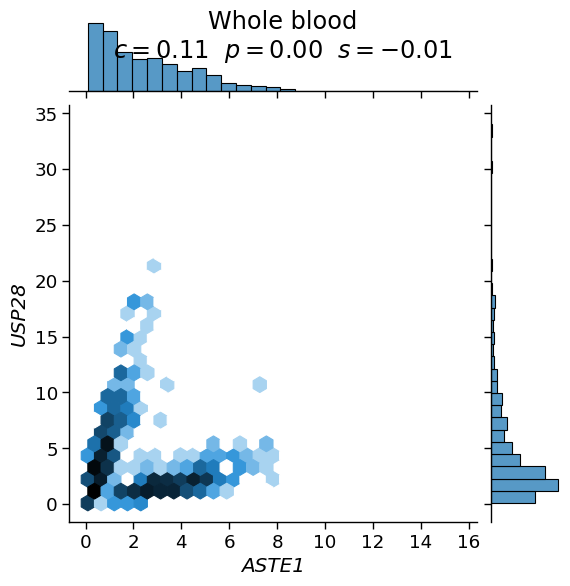

In [60]:
gene0_id, gene1_id = "ENSG00000034533.11 ENSG00000048028.11".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="SEX",
    # kind="scatter",
)

'Full data: (755, 68)'

('MDC1', 'C9orf69')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-MDC1_vs_C9orf69.svg')

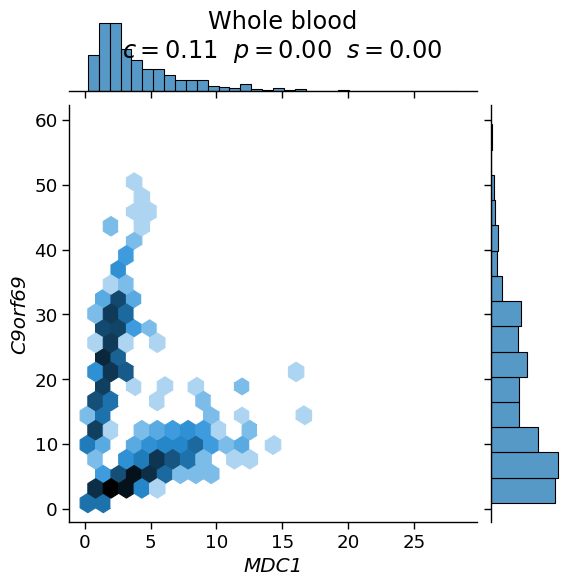

In [57]:
gene0_id, gene1_id = "ENSG00000137337.14 ENSG00000238227.7".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="SEX",
    # kind="scatter",
)

'Full data: (755, 68)'

('CTD-2342N23.1', 'RNA5SP71')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-CTD-2342N23.1_vs_RNA5SP71.svg')

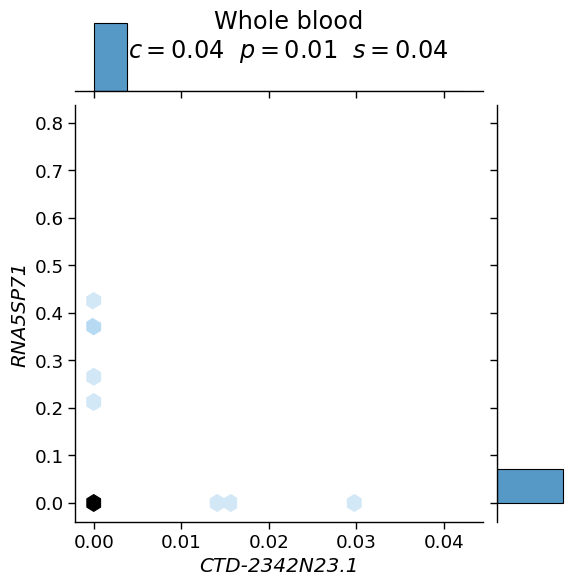

In [51]:
gene0_id, gene1_id = "ENSG00000278898.1 ENSG00000199837.1".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('NREP', 'MAFF')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-NREP_vs_MAFF.svg')

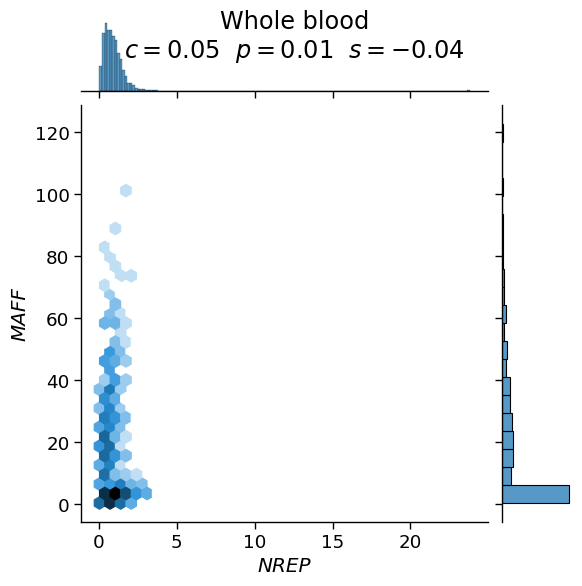

In [50]:
gene0_id, gene1_id = "ENSG00000134986.13 ENSG00000185022.11".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('SUPT20H', 'PPP1R15A')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-SUPT20H_vs_PPP1R15A.svg')

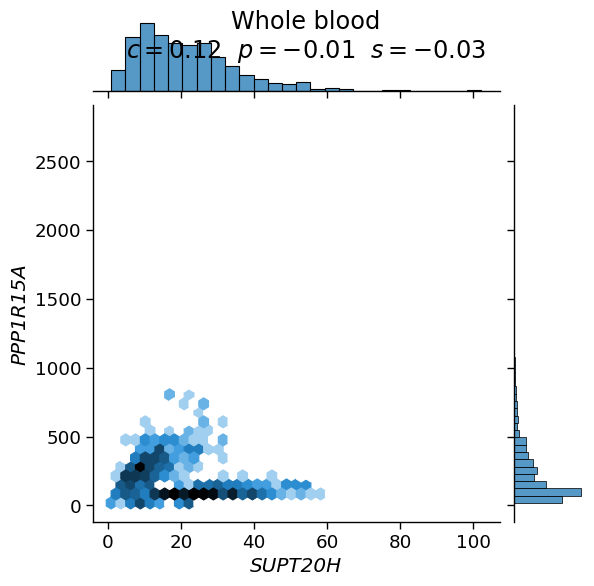

In [45]:
gene0_id, gene1_id = "ENSG00000102710.19 ENSG00000087074.7".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('RP11-51F16.1', 'ARL4C')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-RP11-51F16.1_vs_ARL4C.svg')

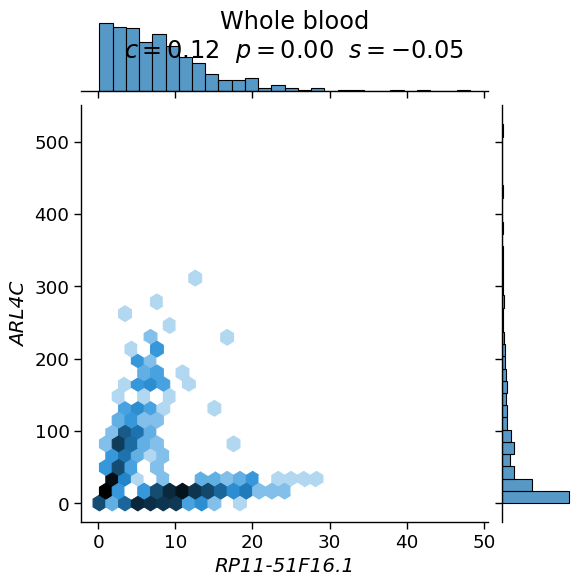

In [44]:
gene0_id, gene1_id = "ENSG00000279369.1  ENSG00000188042.7".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('LACTB2', 'DUSP10')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-LACTB2_vs_DUSP10.svg')

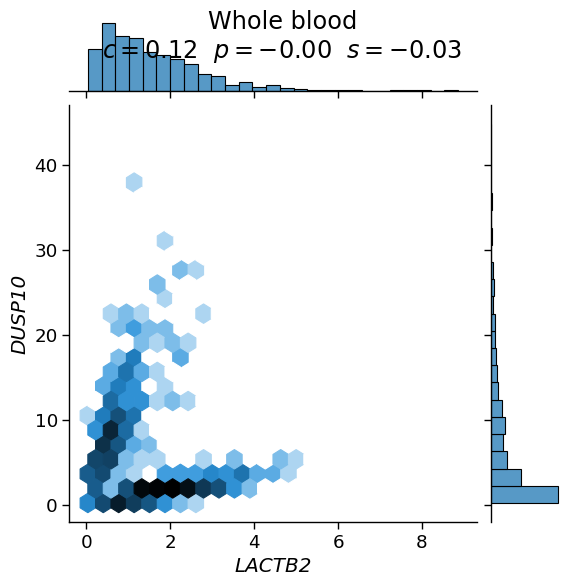

In [43]:
gene0_id, gene1_id = "ENSG00000147592.8  ENSG00000143507.17".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('ZFP36', 'TLR1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-ZFP36_vs_TLR1.svg')

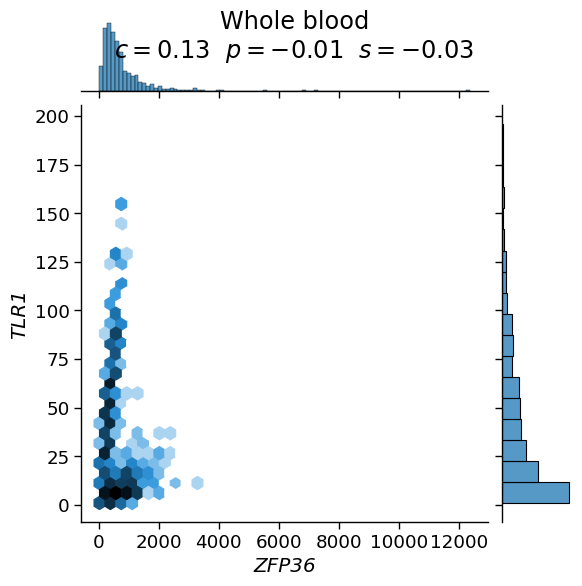

In [42]:
gene0_id, gene1_id = "ENSG00000128016.5  ENSG00000174125.7".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('LINC00846', 'SNORD49A')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-LINC00846_vs_SNORD49A.svg')

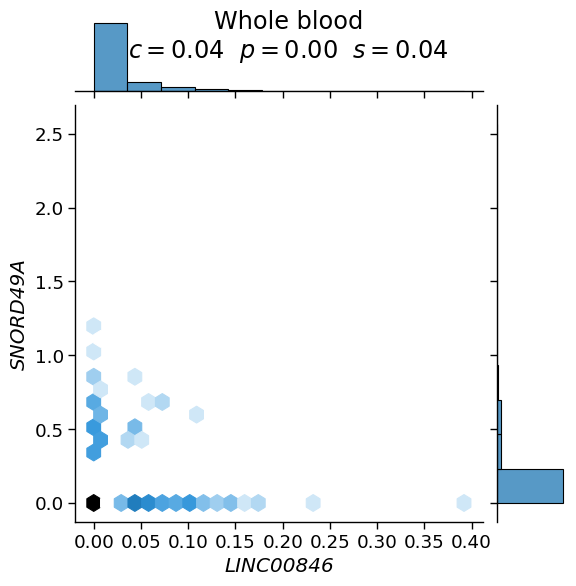

In [41]:
gene0_id, gene1_id = "ENSG00000186842.4  ENSG00000277370.1".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('C5orf58', 'ZBTB18')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-C5orf58_vs_ZBTB18.svg')

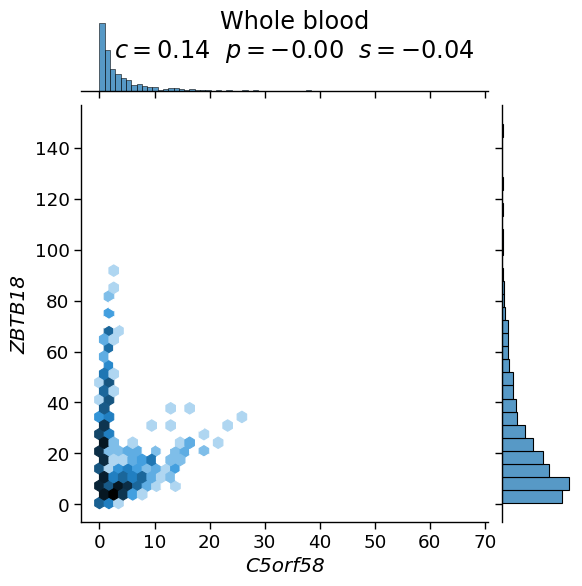

In [40]:
gene0_id, gene1_id = "ENSG00000234511.8  ENSG00000179456.10".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('THAP6', 'GZF1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-THAP6_vs_GZF1.svg')

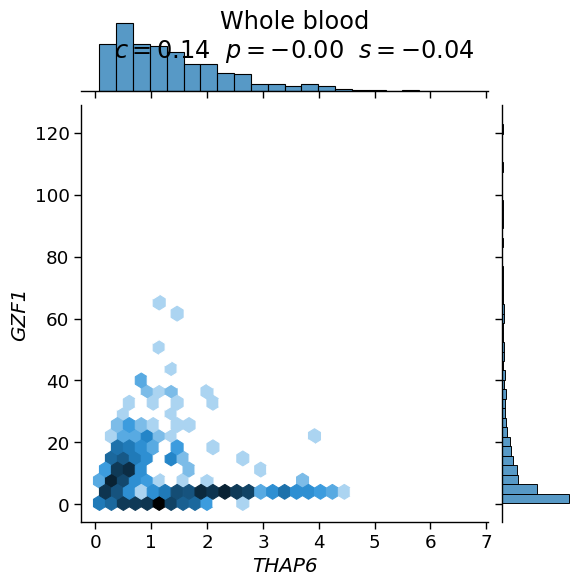

In [39]:
gene0_id, gene1_id = "ENSG00000174796.12 ENSG00000125812.15".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('INIP', 'GZF1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-INIP_vs_GZF1.svg')

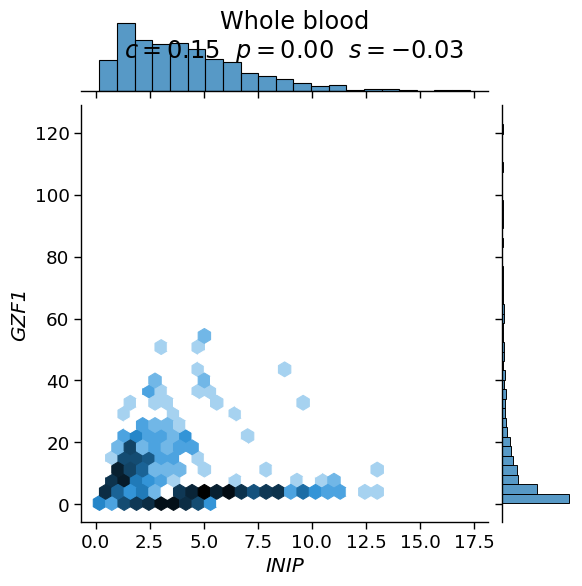

In [38]:
gene0_id, gene1_id = "ENSG00000148153.13 ENSG00000125812.15".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('UTP14C', 'GZF1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-UTP14C_vs_GZF1.svg')

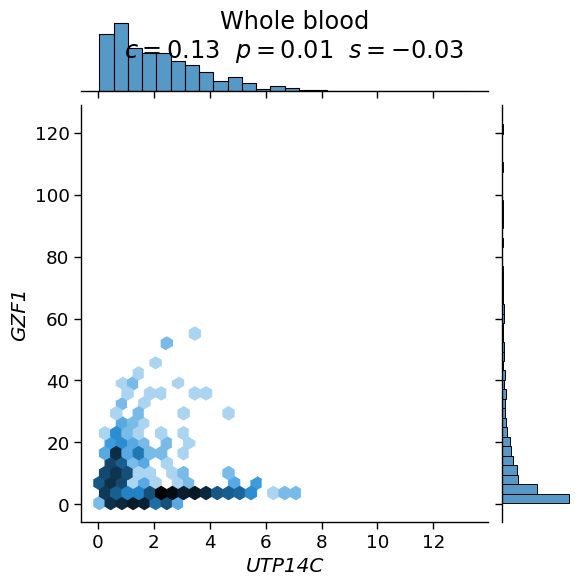

In [37]:
gene0_id, gene1_id = "ENSG00000253797.2  ENSG00000125812.15".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

## Lowest tissues in ccc

'Full data: (515, 253)'

'Full data without NaNs: (515, 253)'

('CYTIP', 'RASSF2')

PosixPath('/opt/manuscript/content/images/coefs_comp/cytip_vs_rassf2/gtex_esophagus_muscularis-CYTIP_vs_RASSF2.svg')

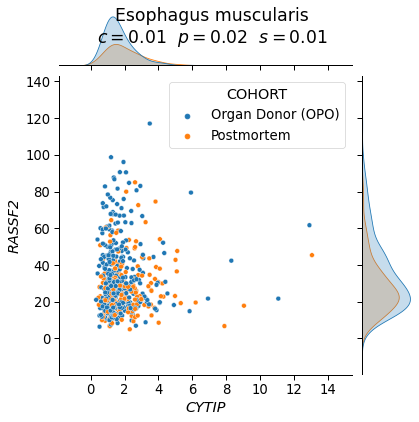

In [37]:
_tissue_data = plot_gene_pair(
    "esophagus_muscularis",
    gene0_id,
    gene1_id,
    hue="COHORT",
    kind="scatter",
)

'Full data: (375, 253)'

'Full data without NaNs: (375, 253)'

('CYTIP', 'RASSF2')

PosixPath('/opt/manuscript/content/images/coefs_comp/cytip_vs_rassf2/gtex_esophagus_gastroesophageal_junction-CYTIP_vs_RASSF2.svg')

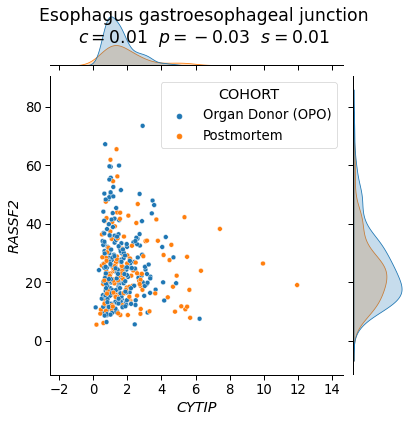

In [38]:
_tissue_data = plot_gene_pair(
    "esophagus_gastroesophageal_junction",
    gene0_id,
    gene1_id,
    hue="COHORT",
    kind="scatter",
)

'Full data: (258, 253)'

'Full data without NaNs: (258, 253)'

('CYTIP', 'RASSF2')

PosixPath('/opt/manuscript/content/images/coefs_comp/cytip_vs_rassf2/gtex_adrenal_gland-CYTIP_vs_RASSF2.svg')

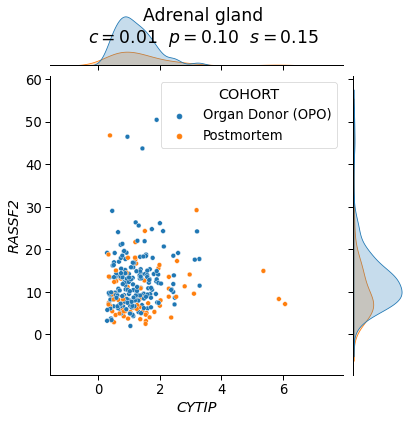

In [39]:
_tissue_data = plot_gene_pair(
    "adrenal_gland",
    gene0_id,
    gene1_id,
    hue="COHORT",
    kind="scatter",
)

'Full data: (432, 253)'

'Full data without NaNs: (432, 253)'

('CYTIP', 'RASSF2')

PosixPath('/opt/manuscript/content/images/coefs_comp/cytip_vs_rassf2/gtex_artery_aorta-CYTIP_vs_RASSF2.svg')

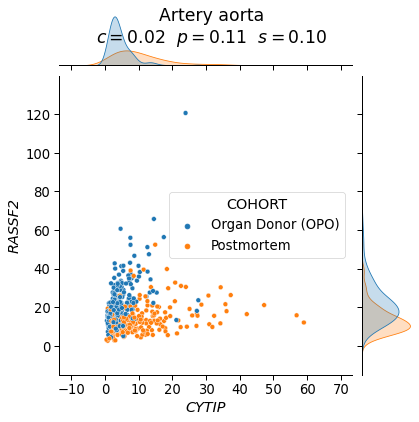

In [40]:
_tissue_data = plot_gene_pair(
    "artery_aorta",
    gene0_id,
    gene1_id,
    hue="COHORT",
    kind="scatter",
)

'Full data: (504, 253)'

'Full data without NaNs: (504, 253)'

('CYTIP', 'RASSF2')

PosixPath('/opt/manuscript/content/images/coefs_comp/cytip_vs_rassf2/gtex_cells_cultured_fibroblasts-CYTIP_vs_RASSF2.svg')

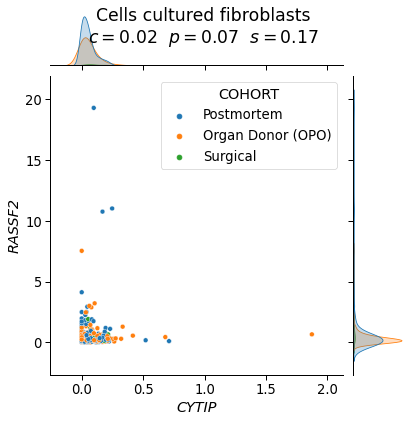

In [41]:
_tissue_data = plot_gene_pair(
    "cells_cultured_fibroblasts",
    gene0_id,
    gene1_id,
    hue="COHORT",
    kind="scatter",
)

'Full data: (373, 253)'

'Full data without NaNs: (373, 253)'

('CYTIP', 'RASSF2')

PosixPath('/opt/manuscript/content/images/coefs_comp/cytip_vs_rassf2/gtex_colon_sigmoid-CYTIP_vs_RASSF2.svg')

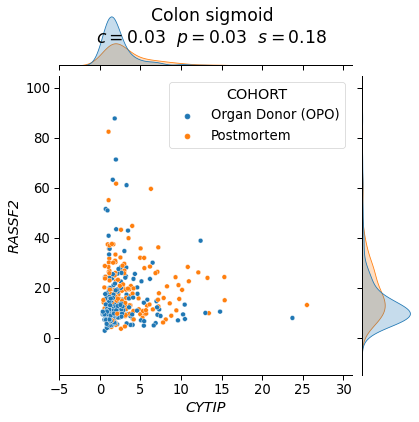

In [42]:
_tissue_data = plot_gene_pair(
    "colon_sigmoid",
    gene0_id,
    gene1_id,
    hue="COHORT",
    kind="scatter",
)

'Full data: (663, 253)'

'Full data without NaNs: (663, 253)'

('CYTIP', 'RASSF2')

PosixPath('/opt/manuscript/content/images/coefs_comp/cytip_vs_rassf2/gtex_artery_tibial-CYTIP_vs_RASSF2.svg')

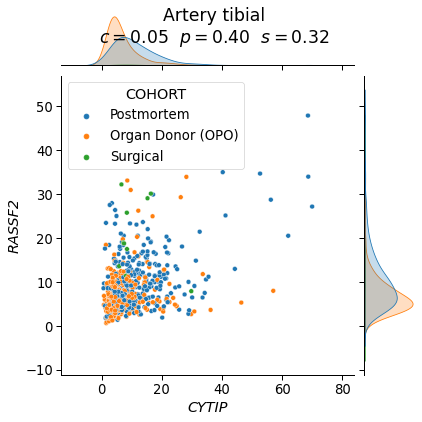

In [43]:
_tissue_data = plot_gene_pair(
    "artery_tibial",
    gene0_id,
    gene1_id,
    hue="COHORT",
    kind="scatter",
)

## Highest tissues in ccc

'Full data: (359, 253)'

'Full data without NaNs: (359, 253)'

('CYTIP', 'RASSF2')

PosixPath('/opt/manuscript/content/images/coefs_comp/cytip_vs_rassf2/gtex_stomach-CYTIP_vs_RASSF2.svg')

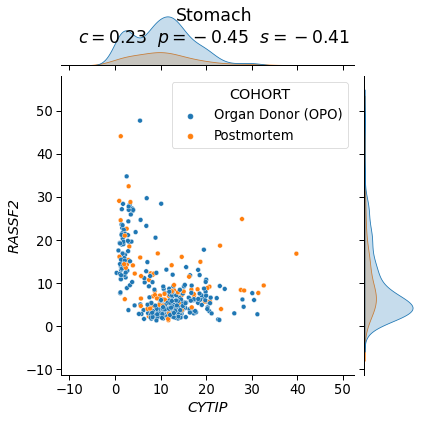

In [52]:
_tissue_data = plot_gene_pair(
    "stomach",
    gene0_id,
    gene1_id,
    hue="COHORT",
    kind="scatter",
)

'Full data: (432, 253)'

'Full data without NaNs: (432, 253)'

('CYTIP', 'RASSF2')

PosixPath('/opt/manuscript/content/images/coefs_comp/cytip_vs_rassf2/gtex_heart_left_ventricle-CYTIP_vs_RASSF2.svg')

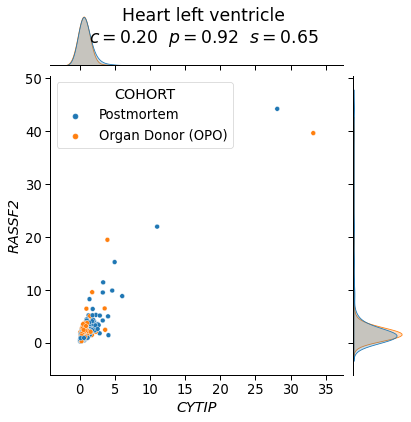

In [63]:
_tissue_data = plot_gene_pair(
    "heart_left_ventricle",
    gene0_id,
    gene1_id,
    hue="COHORT",
    kind="scatter",
)

'Full data: (755, 253)'

'Full data without NaNs: (755, 253)'

('CYTIP', 'RASSF2')

PosixPath('/opt/manuscript/content/images/coefs_comp/cytip_vs_rassf2/gtex_whole_blood-CYTIP_vs_RASSF2.svg')

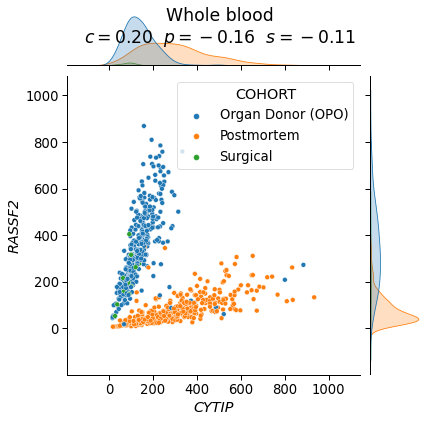

In [66]:
_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    hue="COHORT",
    kind="scatter",
)

'Full data: (803, 253)'

'Full data without NaNs: (803, 253)'

('CYTIP', 'RASSF2')

PosixPath('/opt/manuscript/content/images/coefs_comp/cytip_vs_rassf2/gtex_muscle_skeletal-CYTIP_vs_RASSF2.svg')

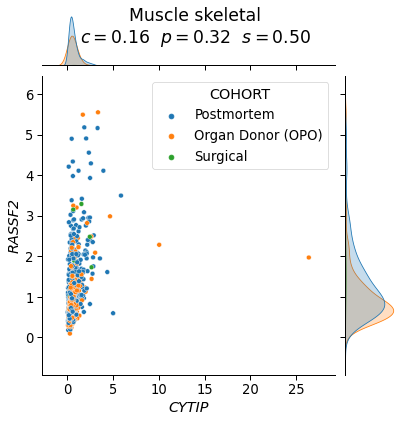

In [64]:
_tissue_data = plot_gene_pair(
    "muscle_skeletal",
    gene0_id,
    gene1_id,
    hue="COHORT",
    kind="scatter",
)

'Full data: (653, 253)'

'Full data without NaNs: (653, 253)'

('CYTIP', 'RASSF2')

PosixPath('/opt/manuscript/content/images/coefs_comp/cytip_vs_rassf2/gtex_thyroid-CYTIP_vs_RASSF2.svg')

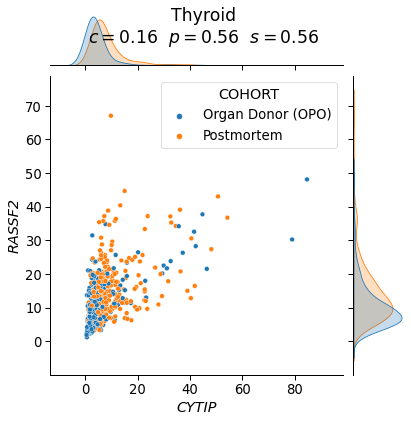

In [65]:
_tissue_data = plot_gene_pair(
    "thyroid",
    gene0_id,
    gene1_id,
    hue="COHORT",
    kind="scatter",
)

## Pearson low, CCC high

'Full data: (755, 253)'

'Full data without NaNs: (755, 253)'

('CYTIP', 'RASSF2')

PosixPath('/opt/manuscript/content/images/coefs_comp/cytip_vs_rassf2/gtex_whole_blood-CYTIP_vs_RASSF2.svg')

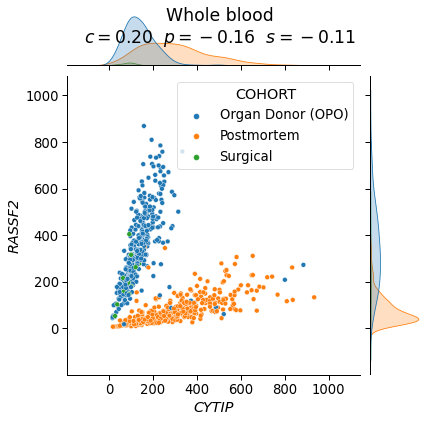

In [55]:
_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    hue="COHORT",
    kind="scatter",
)

'Full data: (406, 253)'

'Full data without NaNs: (406, 253)'

('CYTIP', 'RASSF2')

PosixPath('/opt/manuscript/content/images/coefs_comp/cytip_vs_rassf2/gtex_colon_transverse-CYTIP_vs_RASSF2.svg')

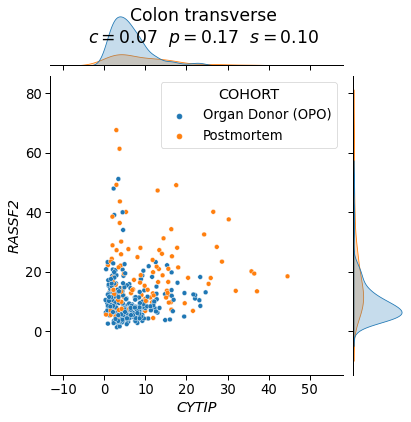

In [58]:
_tissue_data = plot_gene_pair(
    "colon_transverse",
    gene0_id,
    gene1_id,
    hue="COHORT",
    kind="scatter",
)

'Full data: (803, 253)'

'Full data without NaNs: (803, 253)'

('CYTIP', 'RASSF2')

PosixPath('/opt/manuscript/content/images/coefs_comp/cytip_vs_rassf2/gtex_muscle_skeletal-CYTIP_vs_RASSF2.svg')

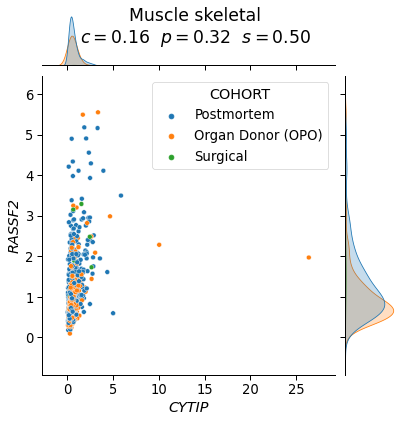

In [59]:
_tissue_data = plot_gene_pair(
    "muscle_skeletal",
    gene0_id,
    gene1_id,
    hue="COHORT",
    kind="scatter",
)

## Spearman low, CCC high

'Full data: (755, 253)'

'Full data without NaNs: (755, 253)'

('CYTIP', 'RASSF2')

PosixPath('/opt/manuscript/content/images/coefs_comp/cytip_vs_rassf2/gtex_whole_blood-CYTIP_vs_RASSF2.svg')

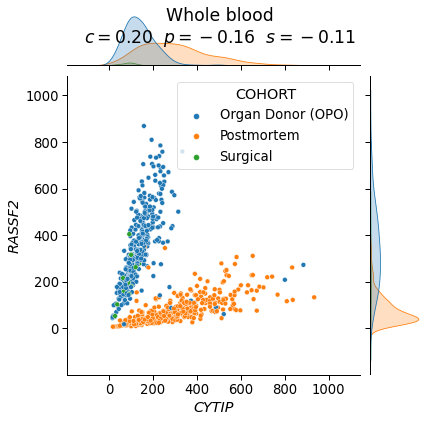

In [61]:
_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    hue="COHORT",
    kind="scatter",
)

'Full data: (359, 253)'

'Full data without NaNs: (359, 253)'

('CYTIP', 'RASSF2')

PosixPath('/opt/manuscript/content/images/coefs_comp/cytip_vs_rassf2/gtex_stomach-CYTIP_vs_RASSF2.svg')

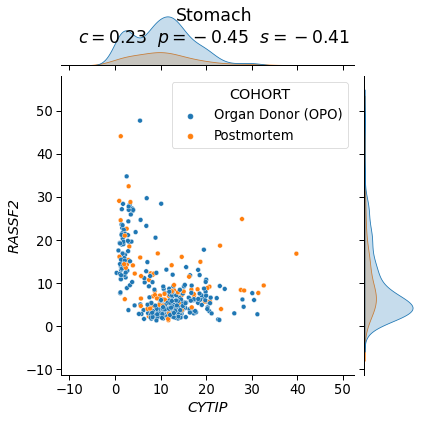

In [62]:
_tissue_data = plot_gene_pair(
    "stomach",
    gene0_id,
    gene1_id,
    hue="COHORT",
    kind="scatter",
)

# Create final figure

In [43]:
from svgutils.compose import Figure, SVG, Panel

In [48]:
Figure(
    "607.67480cm",
    "870.45984cm",
    Panel(
        SVG(OUTPUT_FIGURE_DIR / "gtex_whole_blood-KDM6A_vs_UTY.svg").scale(0.5),
        SVG(OUTPUT_FIGURE_DIR / "gtex_testis-KDM6A_vs_UTY.svg").scale(0.5).move(200, 0),
        SVG(OUTPUT_FIGURE_DIR / "gtex_cells_cultured_fibroblasts-KDM6A_vs_UTY.svg")
        .scale(0.5)
        .move(200 * 2, 0),
    ),
    Panel(
        SVG(OUTPUT_FIGURE_DIR / "gtex_brain_cerebellum-KDM6A_vs_UTY.svg").scale(0.5),
        SVG(OUTPUT_FIGURE_DIR / "gtex_small_intestine_terminal_ileum-KDM6A_vs_UTY.svg")
        .scale(0.5)
        .move(200, 0),
        SVG(OUTPUT_FIGURE_DIR / "gtex_breast_mammary_tissue-KDM6A_vs_UTY.svg")
        .scale(0.5)
        .move(200 * 2, 0),
    ).move(0, 220),
    Panel(
        SVG(
            OUTPUT_FIGURE_DIR
            / "gtex_brain_anterior_cingulate_cortex_ba24-KDM6A_vs_UTY.svg"
        ).scale(0.5),
        SVG(OUTPUT_FIGURE_DIR / "gtex_brain_amygdala-KDM6A_vs_UTY.svg")
        .scale(0.5)
        .move(200, 0),
        SVG(OUTPUT_FIGURE_DIR / "gtex_heart_atrial_appendage-KDM6A_vs_UTY.svg")
        .scale(0.5)
        .move(200 * 2, 0),
    ).move(0, 220 * 2),
    Panel(
        SVG(OUTPUT_FIGURE_DIR / "gtex_vagina-KDM6A_vs_UTY.svg").scale(0.5),
        SVG(OUTPUT_FIGURE_DIR / "gtex_ovary-KDM6A_vs_UTY.svg").scale(0.5).move(200, 0),
        SVG(OUTPUT_FIGURE_DIR / "gtex_uterus-KDM6A_vs_UTY.svg")
        .scale(0.5)
        .move(200 * 2, 0),
    ).move(0, 220 * 3),
).save(OUTPUT_FIGURE_DIR / "gtex-KDM6A_vs_UTY-main.svg")

Now open the file, reside to fit drawing to page, and add a white rectangle to the background.